In [46]:
import polars as pl
from pathlib import Path
from matplotlib import pyplot as plt
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.append('../src')
from download_gaia_lightcurves import get_time_series
from preprocessing import preprocess_lc, pack_light_curve

parquet_list = sorted(list(Path('../data/gaia_qso_period_gt100d/').glob('*.parquet')))
lc_index = {}
for p in parquet_list:
    sids = pl.read_parquet(p, columns=['sourceid']).to_series().to_list()
    for k, s in enumerate(sids):
        lc_index[s] = (p, k)

def get_lc(sid, remove_extreme_errors=True):
    file, rowidx = lc_index[sid]
    df_lc = pl.read_parquet(file, columns=['sourceid', 'g_obstimes', 'g_val', 'g_valerr', 'period']).slice(rowidx, 1)
    if 'period' in df_lc.columns:
        period = df_lc.select('period').to_series().item()
    else:
        period = None
    row = pack_light_curve(df_lc, remove_extreme_errors=remove_extreme_errors)['g']
    time, mag, err = preprocess_lc(row, scale_time=False, center_mag=True, scale_mag=True)
    return time, mag, err, period

# Crossmatching GASP with AGN catalogues


First, we load the GASP sources and bayes factors and append *Gaia* positions, colors and mean magnitude:

In [2]:
df_qso_metadata = pl.read_parquet('../data/gaia_qso_initial_selection.parquet')
df_gasp = pl.read_parquet('../results/bayes_factors.parquet').join(
    df_qso_metadata.select(['sourceid', 'ra', 'dec', 'bp_rp', 'mean_mag_g_fov']), on='sourceid', how='left'
)
display(df_gasp.head(5), len(df_gasp))

sourceid,log_bf_PR,log_bf_PR_std,period,period_std,quasiperiodic,ra,dec,bp_rp,mean_mag_g_fov
i64,f64,f64,f64,f64,bool,f64,f64,f32,f32
2860871050077003264,6.547961,4.884443,485.252702,7.495754,false,3.898343,30.846826,0.77899,19.217627
2799965875494150272,5.807438,4.324529,145.023175,1.142638,false,6.436796,22.45277,1.094103,20.595688
2858120862257789184,5.494289,3.407645,499.048454,7.82076,false,9.56716,29.012361,0.607225,19.343683
1694224002518759808,5.462683,3.653615,448.571547,10.53503,false,226.140435,69.177829,0.775427,19.323778
3135056230337287296,5.293715,3.124158,359.019199,11.753617,false,112.201052,2.063738,0.994131,20.286081


48406

Next, we append identifiers from the surveys listed in the *Gaia* CRF3

In [3]:
%%time

query = """
SELECT source_id, aw15_name, r90_name, c75_name, m65_name, dr14q_name, lqac5_name, guw_name
FROM gaiadr3.gaia_crf3_xm
"""
job = Gaia.launch_job_async(query)
res_crf3 = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 32.9 s, sys: 672 ms, total: 33.6 s
Wall time: 4min 23s


In [4]:
gaia_crf3 = pl.DataFrame(res_crf3.as_array()).rename({'source_id': 'sourceid'}).select(
    ['sourceid', 'aw15_name', 'r90_name', 'c75_name', 'm65_name', 'dr14q_name', 'lqac5_name', 'guw_name']
).rename({
    'r90_name': 'AllWISE_R90_id', #Assef 2018 https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2018ApJS..234...23A
    'c75_name': 'AllWISE_C75_id', # Assef 2018 https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2018ApJS..234...23A
    'guw_name': 'Gaia_unWISE_id', # Shu 2019 https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2019MNRAS.489.4741S
    'aw15_name': 'AllWISE', # Secrest 2015 https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2015ApJS..221...12S
    'm65_name': 'Milliquas_v65_id', # https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=VII/290
    'dr14q_name': 'SDSS_DR14Q_id', # Paris 2018 https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2018A%26A...613A..51P
    'lqac5_name': 'LQAC_v5', # Souchay 2019 https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2019A%26A...624A.145S
})
    
gaia_crf3 = gaia_crf3.with_columns([
    pl.when(pl.col(col) == "").then(None).otherwise(pl.col(col)).alias(col)
    for col in gaia_crf3.columns if col != 'sourceid'
])

df_gasp = df_gasp.join(gaia_crf3, on='sourceid', how='left')

We also append identifiers from recent AGN catalogs, such as Quaia [(Storey-Fisher et al. 2023)](https://arxiv.org/abs/2306.17749)

In [5]:
!wget -c https://zenodo.org/records/8060755/files/quaia_G20.5.fits

--2025-06-06 10:50:37--  https://zenodo.org/records/8060755/files/quaia_G20.5.fits
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 416 REQUESTED_RANGE_NOT_SATISFIABLE

    The file is already fully retrieved; nothing to do.



In [7]:
with fits.open('quaia_G20.5.fits') as hdul:
    table_data = Table(hdul[1].data)
    data_dict = {col: table_data[col].tolist() for col in table_data.colnames}
    df_quaia = pl.DataFrame(data_dict).rename({'source_id':'sourceid'}).with_columns(
        pl.col('unwise_objid').cast(pl.String).alias('Quaia_unwise_id')
    ).select(['sourceid', 'Quaia_unwise_id', 'redshift_quaia'])
    
df_gasp = df_gasp.join(df_quaia, on='sourceid', how='left') 

and [CatNorth (Fu et al. 2024)](https://iopscience.iop.org/article/10.3847/1538-4365/ad2ae6)

In [8]:
%%time

vizier = Vizier()
vizier.ROW_LIMIT = -1
catnorth = vizier.get_catalogs('J/ApJS/271/54')[0]

CPU times: user 1min 50s, sys: 522 ms, total: 1min 51s
Wall time: 1min 52s


In [9]:
df_catnorth = pl.DataFrame(
    {col: catnorth[col].tolist() for col in ['Gaia', 'PS1', 'CATWISE']}
).rename({'Gaia': 'sourceid', 'CATWISE': 'CatNorth_CATWISE2020_id', 'PS1': 'CatNorth_PS1_id'})

In [10]:
df_gasp = df_gasp.join(df_catnorth, on='sourceid', how='left')

In [11]:
df_gasp.rename({'sourceid': 'gaia_dr3_id'}).write_csv('../results/gasp.csv')

# Comparing with SMBHB catalogs in the literature

We start with [Graham et al. 2015](https://academic.oup.com/mnras/article/453/2/1562/1145549) were 111 SMBHB candidates were found among 243,500 spectroscopically confirmed quasars.

Finding *Gaia* DR3 source id for the candidates:

In [13]:
df_graham = pl.read_csv('../data/external/graham2015.dat')

sids_match = []
for row in df_graham.iter_rows(named=True):
    identifier = row['# Id']
    period = row[' period']
    if 'SDSS' in identifier:
        xmatch = gaia_crf3.filter(pl.col('SDSS_DR14Q_id').eq(identifier.replace('SDSS_J', '')))
    else:
        xmatch = gaia_crf3.filter(pl.col('Milliquas_v65_id').eq(identifier))
    if len(xmatch) > 0:
        sids_match.append(
            xmatch.with_columns(
                pl.lit(period).alias('graham_period'),
                pl.lit(identifier).alias('graham_name')
            )
        )
        
graham_in_crf3 = pl.concat(sids_match)

Number of candidates from Graham et al. 2015 that are present in the initial AGN selection used in this work:

In [15]:
len(df_qso_metadata.join(graham_in_crf3, on='sourceid'))

65

Comparison between the period estimated by Graham et al. 2015 and the periods estimated using *Gaia* DR3. The red dashed lines show the limits used in this work to filter the candidates (100 days and T/1.5)

Text(0, 0.5, 'Period from Gaia G time series')

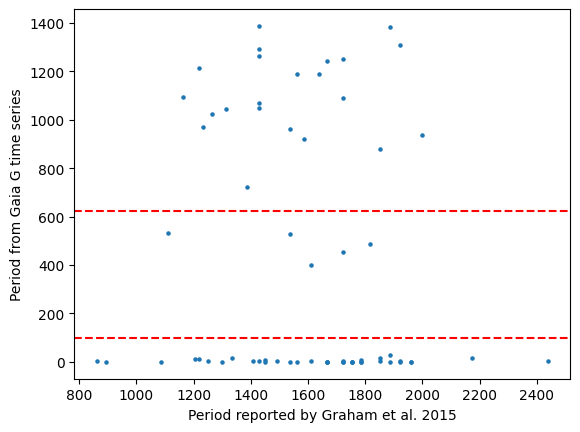

In [24]:
cm_periods = graham_in_crf3.lazy().join(pl.scan_parquet('../results/periods/*.parquet'), on='sourceid').collect()

x, y = cm_periods.select(['graham_period', 'NUFFT_frequency']).to_numpy().T
fig, ax = plt.subplots()
ax.scatter(x, 1/y, s=5)
ax.axhline(100, c='r', ls='--')
ax.axhline(df_qso_metadata.select('time_duration_g_fov').mean().item()/1.5, c='r', ls='--')
ax.set_xlabel('Period reported by Graham et al. 2015')
ax.set_ylabel('Period from Gaia G time series')

> The majority of the reported periods are above the *Gaia* DR3 average time span (933 days). The horizontal line close to zero is associated to the scan-angle of *Gaia*. This frequency is dominant for most cases as not even one cycle of the reported periodicity is observed.

As shown in the above plot, the number of candidates that are present after filtering using the Lomb-Scargle dominant periodicity is

In [16]:
len(df_gasp.join(graham_in_crf3, on='sourceid'))

5

Due to the limited observation baseline of DR3, the *Gaia* light curves of these candidates receive low Bayes factors (DRW model is strongly preferred). The titles show the period estimated from *Gaia* data and the reported (ext) period.

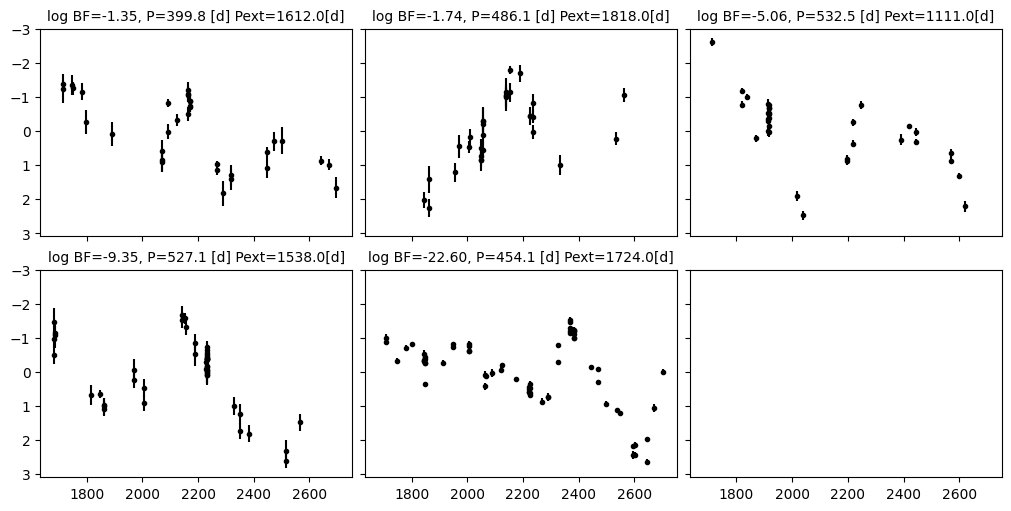

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5), constrained_layout=True, sharex=True, sharey=True)

plot_candidates = df_gasp.join(graham_in_crf3, on='sourceid')

for ax, row in zip(axs.ravel(), plot_candidates.iter_rows(named=True)):
    sid = row['sourceid']
    pexternal = row['graham_period']
    time_, mag_, err_, period_ = get_lc(sid)
    ax.errorbar(time_, mag_, err_, c='k', fmt='.')
    ax.set_title(f'log BF={row["log_bf_PR"]:0.2f}, P={period_:0.1f} [d] Pext={pexternal:0.1f}[d]', fontsize=10)
ax.invert_yaxis();

[PG/PKS 1302-102](https://arxiv.org/abs/1501.01375) is also in the *Gaia* CRF3, however its long 1,884 ± 88 days period is almost twice the time span of Gaia DR3. This time series is not among the 48k sources with *Gaia* periods between 100 and T/1.5 days.

Text(0.5, 1.0, 'Gaia DR3 time series of PG 1302-102 (3622979843899961472)')

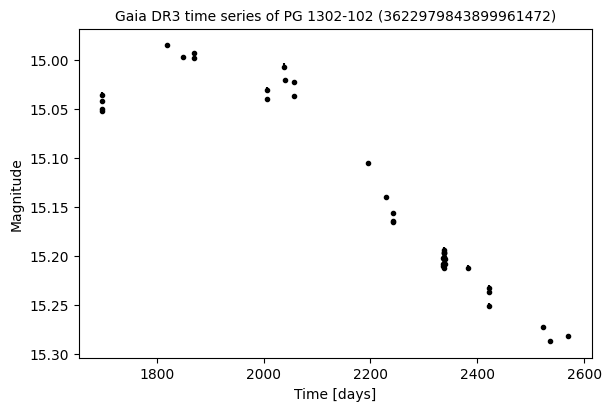

In [56]:
pg1302102_sid = gaia_crf3.filter(pl.col('Milliquas_v65_id').eq("PKS 1302-102")).select('sourceid').item()

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True, sharex=True, sharey=True)
time_, mag_, err_ = pack_light_curve(get_time_series([pg1302102_sid]), remove_extreme_errors=True)['g']
ax.errorbar(time_, mag_, err_, c='k', fmt='.')
ax.invert_yaxis()    
ax.set_ylabel('Magnitude')
ax.set_xlabel('Time [days]')
ax.set_title(f'Gaia DR3 time series of PG 1302-102 ({pg1302102_sid})', fontsize=10);

Next we compare with the candidates by [Charisi et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.2145C/abstract)

In [59]:
df_charisi = pl.read_csv('../data/external/charisi2016.txt')

sids_match = []
for row in df_charisi.iter_rows(named=True):
    identifier = row['Name']
    period = row['Observed Period [days]']
    xmatch = gaia_crf3.filter(pl.col('Milliquas_v65_id').eq(identifier))
    if len(xmatch) > 0:
        sids_match.append(
            xmatch.with_columns(
                pl.lit(period).alias('charisi_period'),
                pl.lit(identifier).alias('charisi_name')
            )
        )
charisi_in_crf3 = pl.concat(sids_match)

Number of candidates from Charisi et al. 2016 that are present in the initial AGN selection used in this work:

In [60]:
len(df_qso_metadata.join(charisi_in_crf3, on='sourceid'))

33

Comparison between the period estimated by Charisi et al. 2016 and the periods estimated using *Gaia* DR3. The red dashed lines show the limits used in this work to filter the candidates (100 days and T/1.5)

Text(0, 0.5, 'Period from Gaia G time series')

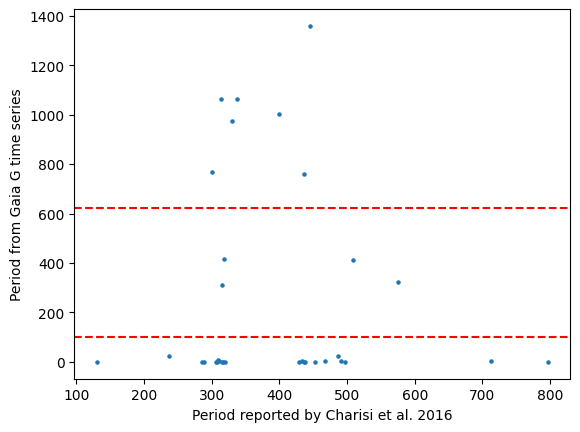

In [67]:
cm_periods = charisi_in_crf3.lazy().join(pl.scan_parquet('../results/periods/*.parquet'), on='sourceid').collect()

x, y = cm_periods.select(['charisi_period', 'NUFFT_frequency']).to_numpy().T
fig, ax = plt.subplots()
ax.scatter(x, 1/y, s=5)
ax.axhline(100, c='r', ls='--')
ax.axhline(df_qso_metadata.select('time_duration_g_fov').mean().item()/1.5, c='r', ls='--')
ax.set_xlabel('Period reported by Charisi et al. 2016')
ax.set_ylabel('Period from Gaia G time series')

> The majority of the candidates from Charisi et al. 2016 have periods that should be detectable given the DR3 time span. However, for most of them, the dominant periodicity is related to the *Gaia* scan-angle, hence they are not selected in this work.

There are four candidates from Charisi et al. 2016 whose periods are within 100 and T/1.5 days. Except for the first one plotted below, the the periods estimated from *Gaia* present large differences with respect to the reported ones. All of these candidates receive a low Bayes factor, meaning that the DRW model is preferred.

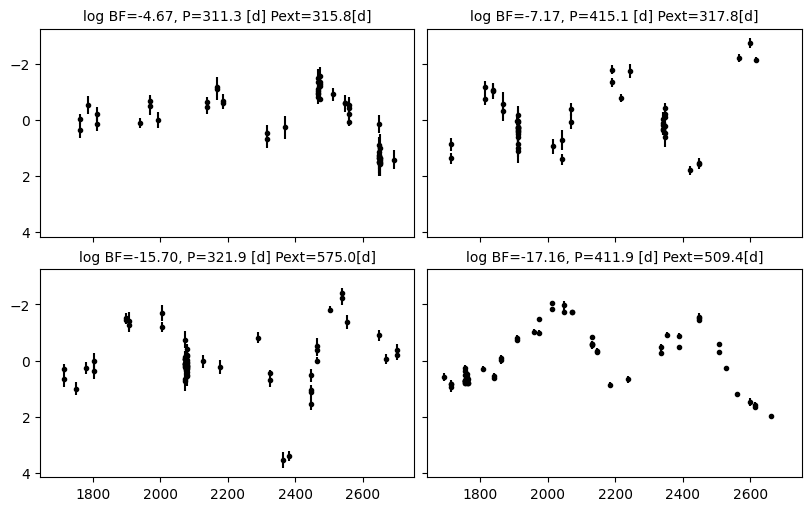

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), constrained_layout=True, sharex=True, sharey=True)

plot_candidates = df_gasp.join(charisi_in_crf3, on='sourceid')

for ax, row in zip(axs.ravel(), plot_candidates.iter_rows(named=True)):
    sid = row['sourceid']
    pexternal = row['charisi_period']
    time_, mag_, err_, period_ = get_lc(sid)
    ax.errorbar(time_, mag_, err_, c='k', fmt='.')
    ax.set_title(f'log BF={row["log_bf_PR"]:0.2f}, P={period_:0.1f} [d] Pext={pexternal:0.1f}[d]', fontsize=10);
ax.invert_yaxis()